# Baseline Fit to Taxi Dataset

This is a copy of `data_processing/01_d_basic_ts_model.ipynb`, modified using the modified taxi data.

### load packages

In [1]:
import sys, os
sys.path.append('..') # add parent directory to path

import numpy as np 
import pandas as pd
from utils import processing as pr
import matplotlib.pyplot as plt
import seaborn as sns

### Load Test Data from Previous Notebook (03_combine_datasets.ipynb)
Consider only pickups from Taxi Zone 79 (East Village)

<Axes: xlabel='pickup_datetime'>

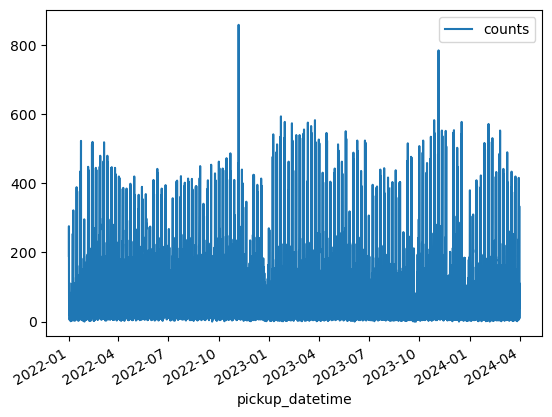

In [64]:
# load data
ts = pd.read_pickle('../../processed_taxi_data/adjusted_yellow_2022-01_2024-03_bypulocation.pkl')

# taxi zone 79
ts_1 = ts[ts['PULocationID'] == 79]
ts_1.plot(x = 'pickup_datetime', y = 'counts')

In [65]:
# basic processing
ts_1.drop(columns = ['PULocationID'], inplace = True) # PULocationID is constant, drop it
ts_1.set_index('pickup_datetime', inplace = True) # time series model packages require datetime index

/tmp/ipykernel_6330/2417320451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_1.drop(columns = ['PULocationID'], inplace = True) # PULocationID is constant, drop it


### Assessing Seasonality of Data
First, let's consider just three weeks of data.

(19358.0, 19385.0)

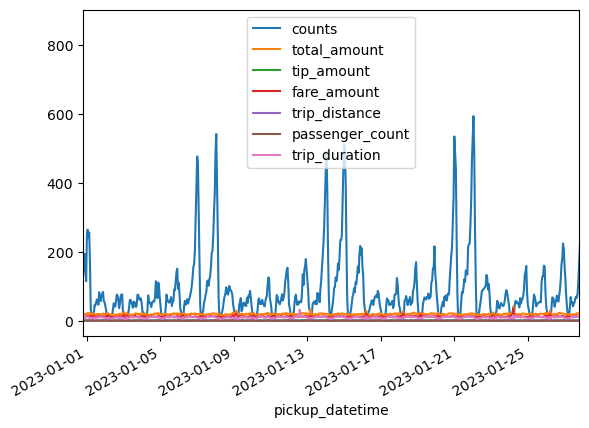

In [66]:
ts_1.plot()
plt.xlim('2023-01-01', '2023-01-28')

As we see, there is `daily seasonality` as there should be high ride activity during the day and low ride activity at night. However, there are weekly patterns. Consider that this is East Village, popular for its clubs and bars. So we expect the area to be more active on weekends at night. This is exactly what we see with the high spikes. This periodic pattern on Fridays, Saturdays, and Sundays is suggestive of `weekly seasonality`. 

### Basic Visualization of Seasonality 
We do this with two methods: the FFT (Fast Fourier Transform) and the ACF (Autocorrelation Function).

In the FFT, peaks will be associated with periodicity. If our time series has a periodicity associated with some frequency, such as $1/24 \ hr^{-1}$, there will be large peaks associated with that frequency and multiples of that frequency (a la Fourier Expansion). You can check that is what we see below. In the ACF, peaks will be associated with seasonality. Unsurprisingly, the main periodicities match.

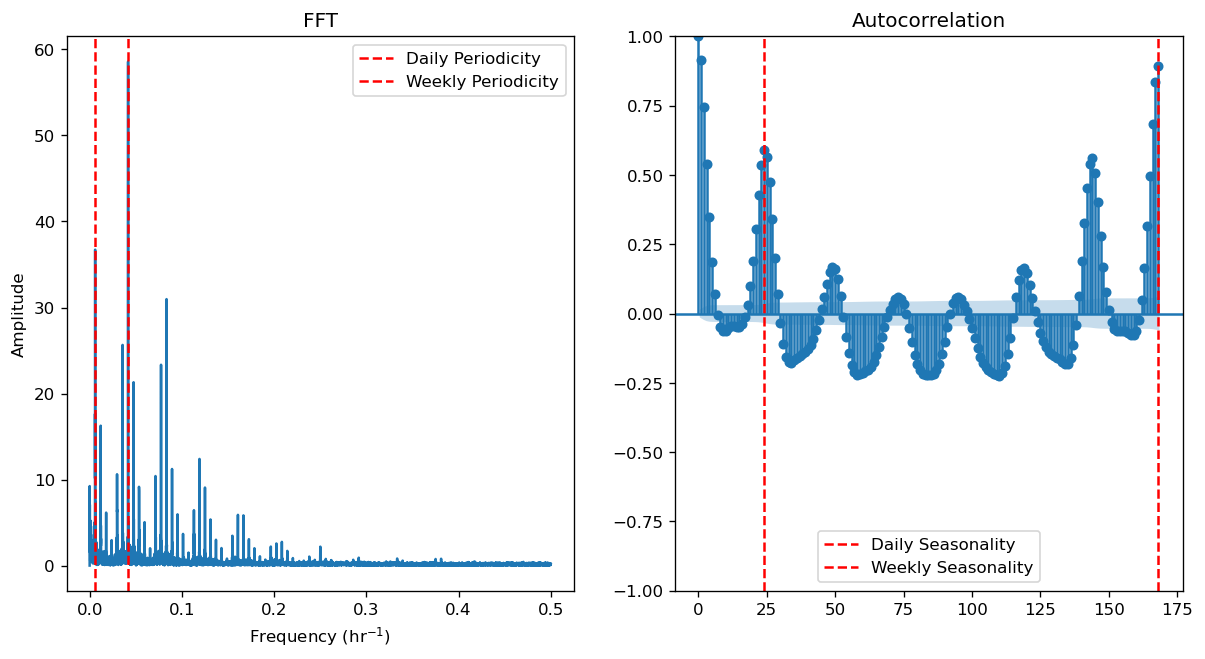

In [67]:
fig, axes = plt.subplots(figsize = (12, 6), dpi = 120, nrows = 1, ncols = 2)

# compute fft
from scipy.fft import fft, fftfreq

N = len(ts_1) # number of samples
T = 1. # sampling interval (one set of counts per hour)
x = np.arange(N) # time axis
y = (ts_1['counts'].values - ts_1['counts'].mean())  # subtract the mean to remove the zeroth-frequency peak
yf = fft(y) # compute the FFT
xf = fftfreq(N, T)[:N//2] # frequency axis

plt.axes(axes[0])
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlabel('Frequency (hr$^{-1}$)')
plt.ylabel('Amplitude')
plt.title('FFT')
plt.axvline(x = 1/24, color = 'red', linestyle = '--', label = 'Daily Periodicity')
plt.axvline(x = 1/(24*7), color = 'red', linestyle = '--', label = 'Weekly Periodicity')
plt.legend()

# compute autocorrelation
from statsmodels.graphics.tsaplots import plot_acf

plt.axes(axes[1])
plot_acf(ts_1['counts'] - ts_1['counts'].mean(), lags = 24*7, ax = axes[1])
plt.axvline(x = 24, color = 'red', linestyle = '--', label = 'Daily Seasonality')
plt.axvline(x = 24*7, color = 'red', linestyle = '--', label = 'Weekly Seasonality')
plt.legend()

### Fitting a Multiseasonal Time Series Model
This isn't obvious and requires some tools that I don't currently understand. First, let's check that difference between subsequent counts is roughly stationary, the ACF, and the PACF.

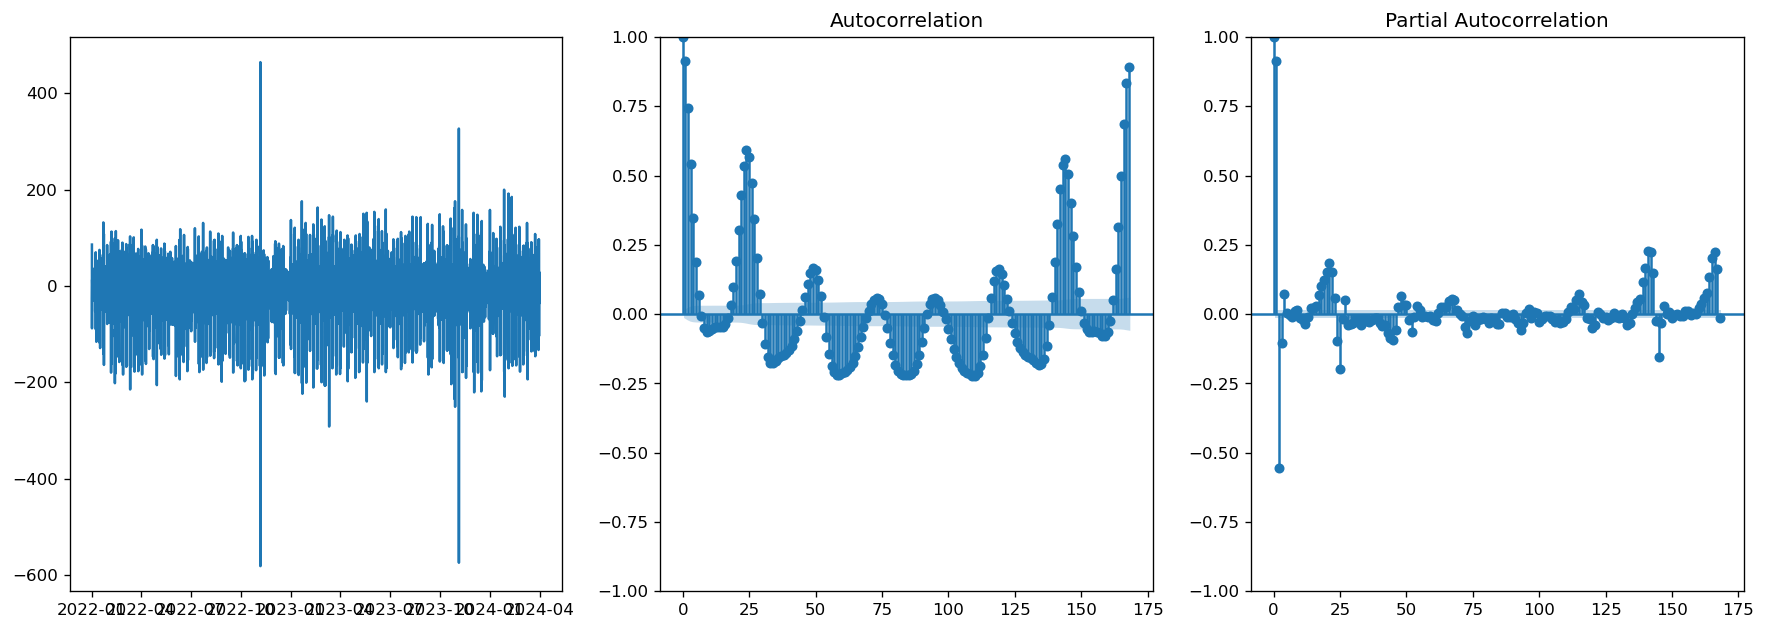

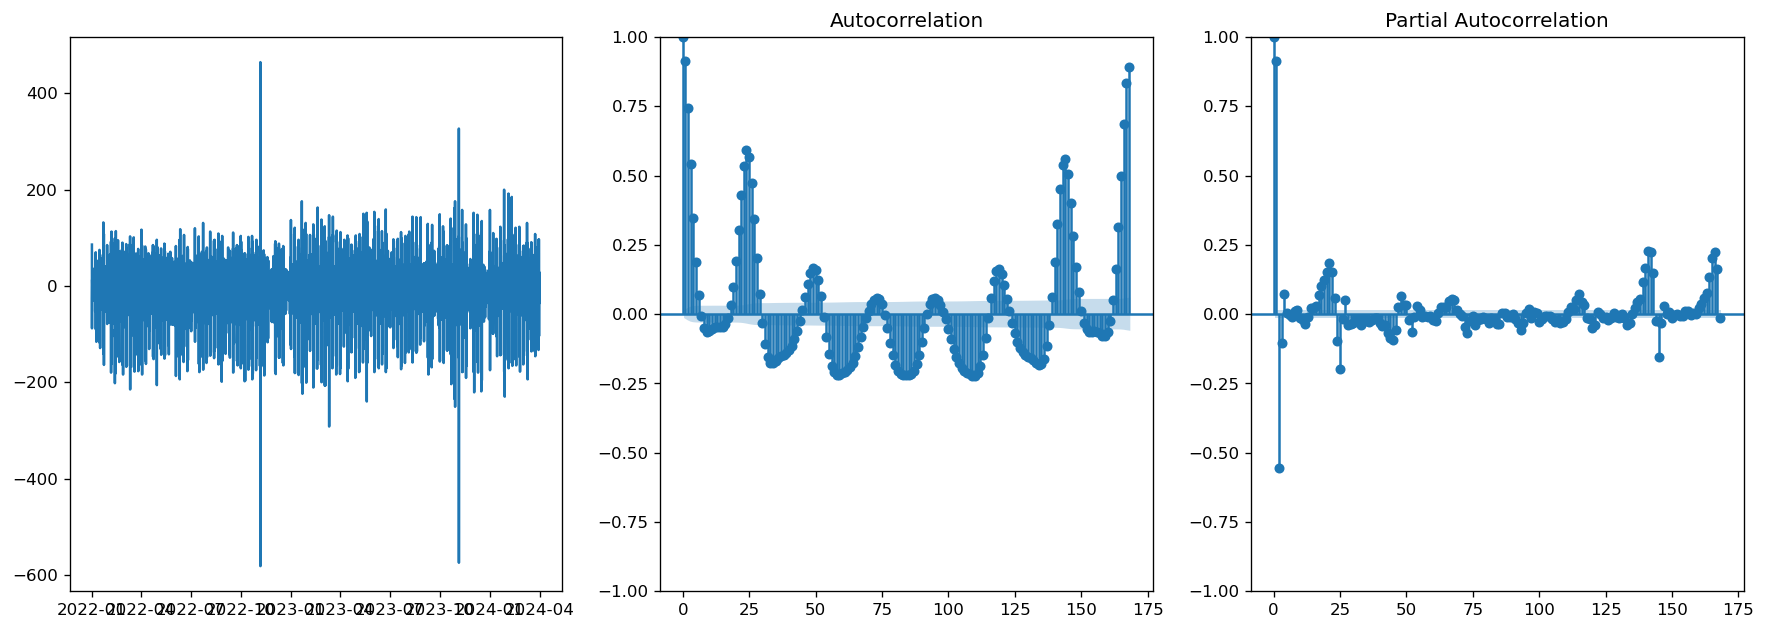

In [68]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(figsize = (18, 6), dpi = 120, nrows = 1, ncols = 3)
plt.axes(axes[0])
plt.plot(ts_1['counts'].diff())
plot_acf(ts_1['counts'] - ts_1['counts'].mean(), lags = 24*7, ax = axes[1])
plot_pacf(ts_1['counts'], lags = 24*7, ax = axes[2])

### Summary:
- The difference time series is reasonably stationary
- The ACF warrants a MA model (see SARIMA notebook from Erdos DS Bootcamp)
- The PACF warrants a AR model (see SARIMA notebook from Erdos DS Bootcamp)

This will educate the SARIMA model that we train below. 

### SARIMA Model:
Implementing a multi-seasonal SARIMA model is not obvious. I was able to write up a decent model with the help of Chat-GPT and playing with the parameters according to the above findings. See https://stackoverflow.com/questions/68923679/forecasting-time-series-with-multiple-seasonaliy-by-using-auto-arimasarimax-an for more details too. From my understanding, the code below performs a standard SARIMA fit with parameters that I found performed well. The seasonality is accounted for by specifying the underlying periodic trend with a Fourier Expansion for each specified frequency.

Our model will predict $\log$-counts, as this will ensure that predictions are non-negative. However, as we will see, I think this causes the errors to grow exponentially with time.

In [283]:
ts_data.reset_index().index[ts_data.reset_index()['pickup_datetime'] == ('2022-10-19 14:00:00-0400')].tolist(), ts_data.reset_index().index[ts_data.reset_index()['pickup_datetime'] == ('2023-03-30 23:00:00-0400')].tolist()

([6973], [10869])

In [281]:
ts_data.reset_index()

,pickup_datetime,log_counts
0,2022-01-01 00:00:00-05:00,5.252273
1,2022-01-01 01:00:00-05:00,5.624018
2,2022-01-01 02:00:00-05:00,5.556828
3,2022-01-01 03:00:00-05:00,5.327876
4,2022-01-01 04:00:00-05:00,4.770685
...,...,...
19622,2024-03-31 19:00:00-04:00,4.543295
19623,2024-03-31 20:00:00-04:00,4.709530
19624,2024-03-31 21:00:00-04:00,4.553877
19625,2024-03-31 22:00:00-04:00,4.189655


In [278]:
ts_data.reset_index().loc[6973]

pickup_datetime    2022-10-19 14:00:00-04:00
log_counts                          4.234107
Name: 6973, dtype: object

In [289]:
exog_test.shape, N_test

((3896, 26), 3945)

In [290]:
ts_test

pickup_datetime
2023-10-19 14:00:00-04:00    4.127134
2023-10-19 15:00:00-04:00    4.025352
2023-10-19 16:00:00-04:00    4.189655
2023-10-19 17:00:00-04:00    4.276666
2023-10-19 18:00:00-04:00    4.682131
                               ...   
2024-03-31 19:00:00-04:00    4.543295
2024-03-31 20:00:00-04:00    4.709530
2024-03-31 21:00:00-04:00    4.553877
2024-03-31 22:00:00-04:00    4.189655
2024-03-31 23:00:00-04:00    4.007333
Name: log_counts, Length: 3945, dtype: float64

/tmp/ipykernel_6330/1516090238.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_1['log_counts'] = np.log(1. + ts_1['counts'])
/tmp/ipykernel_6330/1516090238.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_1['std_log_counts'] = (ts_1['log_counts'] - ts_1['log_counts'].mean()) / ts_1['log_counts'].std()
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency informa

Optimization terminated successfully.
         Current function value: 0.472131
         Iterations: 1
         Function evaluations: 242
                               SARIMAX Results                                
Dep. Variable:             log_counts   No. Observations:                15682
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -7403.951
Date:                Wed, 21 Aug 2024   AIC                          14865.901
Time:                        13:02:16   BIC                          15088.047
Sample:                             0   HQIC                         14939.446
                              - 15682                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin_1         -0.7688      0.026    -29.273      0.000      -0.820      

/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/edr/mambaforge/envs/taxi-forecast/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/tmp/ipykernel_6330/1516090238.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=ts_test.index[0], periods=N_test, freq='H')


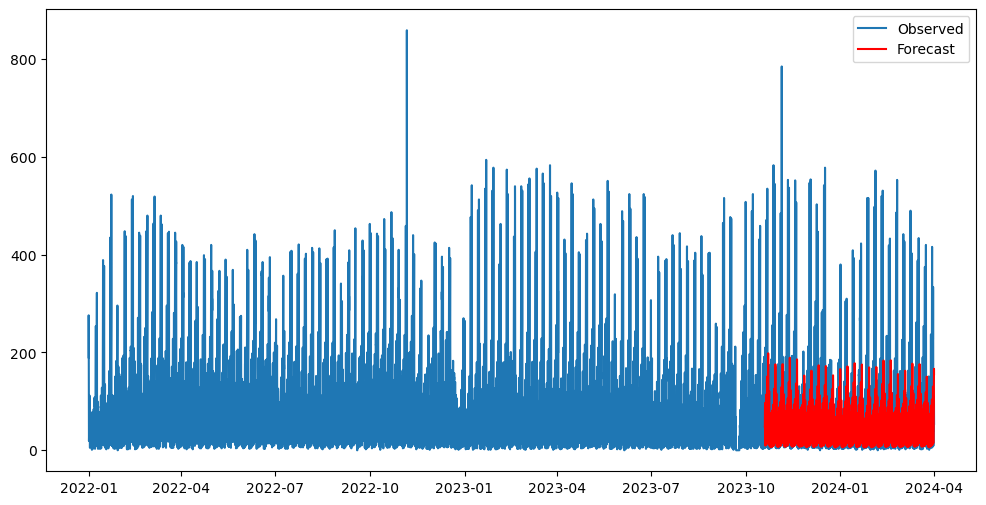

In [291]:
import statsmodels.api as sm

# Example time series data (counts per hour for one week)
# Replace this array with your actual data
ts_1['log_counts'] = np.log(1. + ts_1['counts'])
ts_1['std_log_counts'] = (ts_1['log_counts'] - ts_1['log_counts'].mean()) / ts_1['log_counts'].std()
ts_data = ts_1['counts']

# Split data into training and validation sets
# begin = '2023-09-10 00:00:00-0400'
# ts_data = ts_1['log_counts'][begin:]
ts_data = ts_1['log_counts']
test_start = '2023-10-19 14:00:00-0400'
ts_train = ts_data.loc[:test_start].iloc[:-1]
ts_test = ts_data.loc[test_start:]
N_train = len(ts_train) ; N_test = len(ts_test)

# Split data into training and validation sets
# test_start = '2023-03-01 14:00:00-0400'
# ts_train = ts_1['log_counts'].loc[:test_start].iloc[:-1]
# ts_test = ts_1['log_counts'].loc[test_start:]
# print(len(ts_train), len(ts_test))
# N_train = len(ts_train) ; N_test = len(ts_test)

def create_fourier_terms(series, period, K):
    t = np.arange(len(series))
    terms = pd.DataFrame({
        f'sin_{i}': np.sin(2 * np.pi * i * t / period) for i in range(1, K + 1)
    }).join(pd.DataFrame({
        f'cos_{i}': np.cos(2 * np.pi * i * t / period) for i in range(1, K + 1)
    }))
    return terms

# Create Fourier terms for daily (24-hour) and weekly (168-hour) seasonality
periods = [24, 24*7, 24*30, 24*365]
Ks = [4, 4, 4, 1]
fourier_list_train = [create_fourier_terms(ts_data, period=period, K=Ks[i])[:N_train] for i, period in enumerate(periods)] # Kth-order Fourier terms for each period
fourier_list_test = [create_fourier_terms(ts_data, period=period, K=Ks[i])[6973:(6973 + 3945)] for i, period in enumerate(periods)]
# fourier_list_train = [create_fourier_terms(ts_data, period=period, K=Ks[i])[:N_train] for i, period in enumerate(periods)] # Kth-order Fourier terms for each period
# fourier_list_test = [create_fourier_terms(ts_data, period=period, K=Ks[i])[N_train:] for i, period in enumerate(periods)]

# Combine exogenous variables
exog_train = pd.concat(fourier_list_train, axis=1)
exog_train.index = ts_train.index

exog_test = pd.concat(fourier_list_test, axis=1)
exog_test

# Fit SARIMAX model with exogenous variables for multiple seasonalities
sarimax_model = sm.tsa.statespace.SARIMAX(ts_train, order=(1, 1, 1), exog=exog_train).fit(
    maxiter = 100, method = 'powell'
    )

# Print model summary
print(sarimax_model.summary())

# Forecasting
forecast = sarimax_model.get_forecast(steps=N_test, exog=exog_test)
forecast_index = pd.date_range(start=ts_test.index[0], periods=N_test, freq='H')
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(np.exp(ts_data) - 1., label='Observed')
plt.plot(np.exp(forecast_series) - 1., label='Forecast', color='red')
plt.legend()
plt.show()

# Plotting
# plt.figure(figsize=(12, 6))
# plt.plot(np.exp(ts_data * ts_1['log_counts'].std() + ts_1['log_counts'].mean()) - 1., label='Observed')
# plt.plot(np.exp(forecast_series * ts_1['log_counts'].std() + ts_1['log_counts'].mean()) - 1., label='Forecast', color='red')
# plt.legend()
# plt.show()

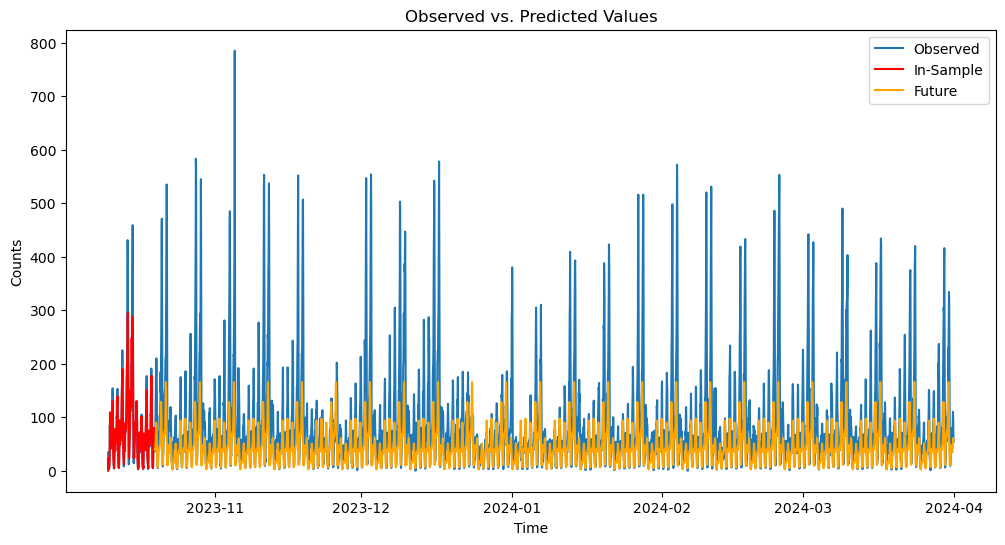

In [244]:
# Generate in-sample predictions
in_sample_predictions = sarimax_model.get_prediction(start= ts_train.index[0], end= ts_train.index[-1], exog=exog_train)
predicted_mean = in_sample_predictions.predicted_mean

# Plot observed vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(np.exp(ts_data) - 1., label='Observed')
plt.plot(np.exp(predicted_mean) - 1., label='In-Sample', color='red')
plt.plot(np.exp(forecast_series) - 1., label='Future', color='orange')
plt.legend()
plt.title('Observed vs. Predicted Values')
plt.xlabel('Time')
plt.ylabel('Counts')
plt.show()

That's a nice fit and non-negativity is cool too. However, this model has exploding confidence intervals.

In [9]:
from datetime import timedelta
# Forecasting
preds_df = sarimax_model.get_prediction(start = ts_test.index[0], end = ts_test.index[-1], exog=exog_test).summary_frame(alpha = 0.05)
pred_index = ts_test.index

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(ts_data.index, ts_data, label='Observed')
plt.plot(preds_df.index, preds_df['mean'], label='Forecast', color='red')
plt.fill_between(preds_df.index, preds_df['mean_ci_lower'], preds_df['mean_ci_upper'], color='red', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('$\log$ Counts')
plt.legend()
plt.show()

<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_6330/473092537.py:12: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log$ Counts')
/tmp/ipykernel_6330/473092537.py:12: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log$ Counts')


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

### Let's compare predictions in-sample

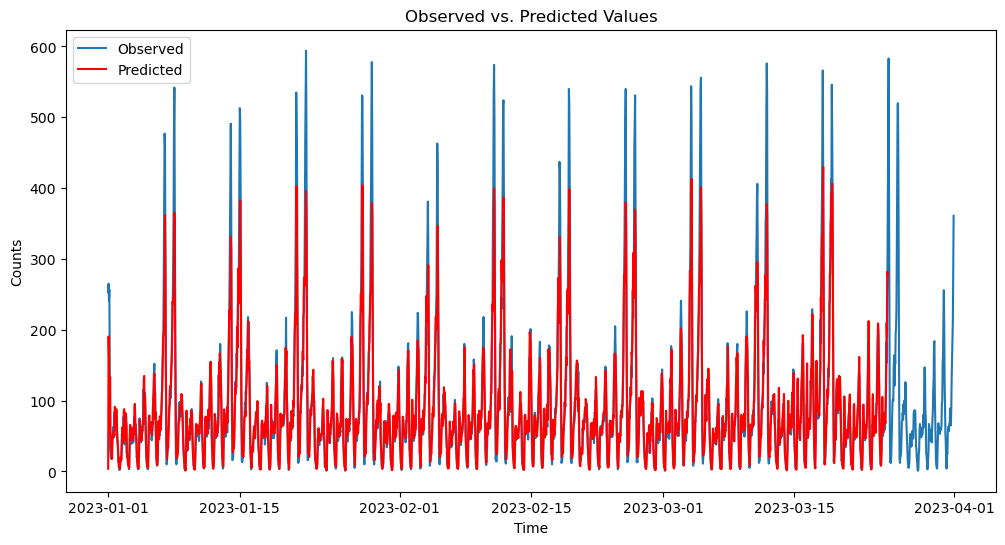

In [10]:
# Generate in-sample predictions
in_sample_predictions = sarimax_model.get_prediction(start= ts_train.index[0], end= ts_train.index[-1], exog=exog_train)
predicted_mean = in_sample_predictions.predicted_mean

# Plot observed vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(np.exp(ts_data), label='Observed')
plt.plot(np.exp(predicted_mean), label='Predicted', color='red')
plt.legend()
plt.title('Observed vs. Predicted Values')
plt.xlabel('Time')
plt.ylabel('Counts')
plt.show()

Not perfect. But, pretty good for a baseline. It might improve if we add more exogenous variables (corresponding to the other peaks in the peaks in the ACF corresponding to 6 days, etc.).